In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, jarque_bera, kstest, anderson, f_oneway, levene, bartlett, kruskal, ttest_ind
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats

## Przygotowanie danych

In [ ]:
url = "https://drive.google.com/uc?id=1pRCFwb3-6KCIRrHDnibVuhHt_6cI4p-z"
data = pd.read_csv(url)

In [ ]:
data['Data'] = pd.to_datetime(data['Data'])
data = data.sort_values('Data').reset_index(drop=True)
data = data.set_index("Data").sort_index()

In [ ]:
all_days = pd.date_range(data.index.min(), data.index.max(), freq="B")
data = data.reindex(all_days)
data["Zamkniecie"] = data["Zamkniecie"].ffill()
data['DzienTygodnia'] = data.index.dayofweek
data['NazwaDnia'] = data.index.day_name()

In [ ]:
data.isnull().sum()

,0
Otwarcie,96
Najwyzszy,96
Najnizszy,96
Zamkniecie,0
Wolumen,96
DzienTygodnia,0
NazwaDnia,0


In [ ]:
def oblicz_stopy_zwrotu(data, dzien_tygodnia):
    data_dzien = data[data['DzienTygodnia'] == dzien_tygodnia].copy()

    if len(data_dzien) < 2:
        return pd.DataFrame()

    data_dzien['Zwykla_Stopa'] = data_dzien['Zamkniecie'].pct_change()
    data_dzien['Log_Stopa'] = np.log(data_dzien['Zamkniecie'] / data_dzien['Zamkniecie'].shift(1))

    return data_dzien.reset_index()

dni_tygodnia = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday'
}

wyniki = {}

for dzien_num, dzien_nazwa in dni_tygodnia.items():
    data_wynik = oblicz_stopy_zwrotu(data, dzien_num)
    wyniki[dzien_nazwa] = data_wynik

### Statystyki opisowe

In [ ]:
def podstawowe_statystyki(stopy_zwrotu, nazwa):
    stopy = stopy_zwrotu.dropna()

    statystyki = {
        'Nazwa': nazwa,
        'Liczba obserwacji': len(stopy),
        'Średnia': stopy.mean(),
        'Mediana': stopy.median(),
        'Min': stopy.min(),
        'Max': stopy.max(),
        'Odch. std': stopy.std(),
        'Wariancja': stopy.var(),
        'Skośność': stats.skew(stopy),
        'Kurtoza': stats.kurtosis(stopy),
        'Zakres': stopy.max() - stopy.min()
    }

    return statystyki


In [ ]:
stat_zwykle = []
for dzien, df in wyniki.items():
    stat = podstawowe_statystyki(df['Zwykla_Stopa'], dzien)
    stat_zwykle.append(stat)

df_stat_zwykle = pd.DataFrame(stat_zwykle)
print("Statystyki opisowe - Zwykła Stopa")
print(df_stat_zwykle.to_string(index=False))

stat_log = []
for dzien, df in wyniki.items():
    stat = podstawowe_statystyki(df['Log_Stopa'], dzien)
    stat_log.append(stat)

df_stat_log = pd.DataFrame(stat_log)
print("\nStatystyki opisowe - Logarytmiczna Stopa")
print(df_stat_log.to_string(index=False))

Statystyki opisowe - Zwykła Stopa
    Nazwa  Liczba obserwacji  Średnia  Mediana       Min      Max  Odch. std  Wariancja  Skośność   Kurtoza   Zakres
   Monday                529 0.002342 0.003920 -0.131230 0.173974   0.023943   0.000573 -0.238937  8.358014 0.305204
  Tuesday                529 0.002284 0.003789 -0.122488 0.070185   0.020910   0.000437 -1.151958  5.456453 0.192673
Wednesday                529 0.002287 0.004403 -0.125222 0.113127   0.022037   0.000486 -1.100687  5.874564 0.238349
 Thursday                529 0.002234 0.003463 -0.179666 0.104048   0.022464   0.000505 -1.260162 10.792079 0.283715
   Friday                530 0.002278 0.003656 -0.149796 0.121017   0.023210   0.000539 -0.613034  6.540633 0.270813

Statystyki opisowe - Logarytmiczna Stopa
    Nazwa  Liczba obserwacji  Średnia  Mediana       Min      Max  Odch. std  Wariancja  Skośność   Kurtoza   Zakres
   Monday                529 0.002052 0.003912 -0.140676 0.160395   0.024023   0.000577 -0.592185  7.8864

### Testy normalności

In [ ]:
def testy_normalnosci(series, dzien):
    wyniki_test = {"Dzien": dzien}
    df = series.dropna()

    stat, p = shapiro(df)
    wyniki_test["Shapiro_Stat"] = stat
    wyniki_test["Shapiro_p"] = p

    stat, p = jarque_bera(df)
    wyniki_test["JB_Stat"] = stat
    wyniki_test["JB_p"] = p

    ad_res = anderson(df, dist="norm")
    wyniki_test["AD_Stat"] = ad_res.statistic
    wyniki_test["AD_Critical_5%"] = ad_res.critical_values[ad_res.significance_level.tolist().index(5.0)]

    return wyniki_test


print("TESTY NORMALNOŚCI - ZWYKŁA STOPA ZWROTU")
norm = []
for dzien, df in wyniki.items():
    stat = testy_normalnosci(df['Zwykla_Stopa'], dzien)
    norm.append(stat)

df_norm_zwykle = pd.DataFrame(norm)
print(df_norm_zwykle.to_string(index=False))

print("\nTESTY NORMALNOŚCI - LOGARYTMICZNA STOPA ZWROTU")
norm_log = []
for dzien, df in wyniki.items():
    stat = testy_normalnosci(df['Log_Stopa'], dzien)
    norm_log.append(stat)

df_norm_log = pd.DataFrame(norm_log)
print(df_norm_log.to_string(index=False))


TESTY NORMALNOŚCI - ZWYKŁA STOPA ZWROTU
    Dzien  Shapiro_Stat    Shapiro_p     JB_Stat          JB_p   AD_Stat  AD_Critical_5%
   Monday      0.902448 6.987773e-18 1544.784895  0.000000e+00 10.445640           0.781
  Tuesday      0.920987 4.979336e-16  773.241588 1.238005e-168  9.259393           0.781
Wednesday      0.913814 8.844701e-17  867.483961 4.248653e-189  9.421419           0.781
 Thursday      0.900763 4.886509e-18 2707.179443  0.000000e+00  7.560406           0.781
   Friday      0.926160 1.787862e-15  977.918878 4.442359e-213  6.681535           0.781

TESTY NORMALNOŚCI - LOGARYTMICZNA STOPA ZWROTU
    Dzien  Shapiro_Stat    Shapiro_p     JB_Stat          JB_p   AD_Stat  AD_Critical_5%
   Monday      0.899453 3.710655e-18 1401.832947 3.943150e-305 11.067825           0.781
  Tuesday      0.909018 2.947633e-17 1072.502143 1.285638e-233 10.199328           0.781
Wednesday      0.902431 6.962747e-18 1133.455712 7.468261e-247 10.526510           0.781
 Thursday      0.88274

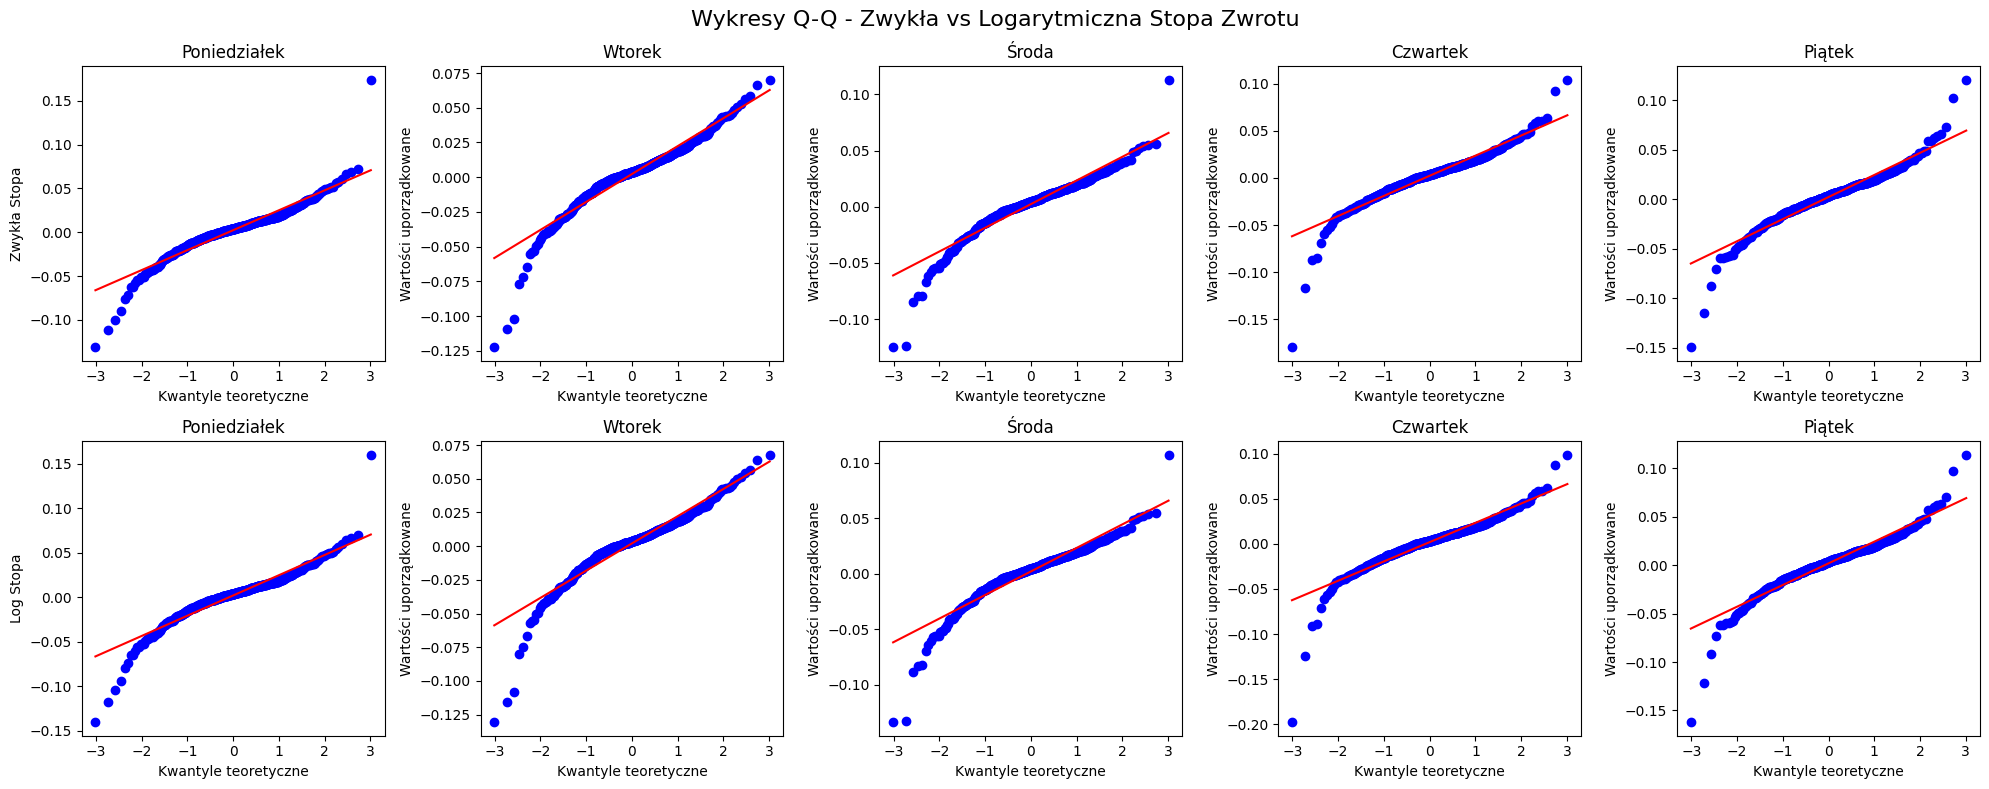

In [ ]:
# Wykresy Q-Q
dni_tygodnia_pl = {
    'Monday': 'Poniedziałek',
    'Tuesday': 'Wtorek',
    'Wednesday': 'Środa',
    'Thursday': 'Czwartek',
    'Friday': 'Piątek',
    'Saturday': 'Sobota',
    'Sunday': 'Niedziela'
}

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Wykresy Q-Q - Zwykła vs Logarytmiczna Stopa Zwrotu', fontsize=16)

for idx, (dzien, df) in enumerate(wyniki.items()):
    stopy = df['Zwykla_Stopa'].dropna()
    stats.probplot(stopy, dist="norm", plot=axes[0, idx])
    axes[0, idx].set_title(dni_tygodnia_pl.get(dzien, dzien))
    axes[0, idx].set_xlabel('Kwantyle teoretyczne')
    axes[0, idx].set_ylabel('Wartości uporządkowane')

for idx, (dzien, df) in enumerate(wyniki.items()):
    stopy = df['Log_Stopa'].dropna()
    stats.probplot(stopy, dist="norm", plot=axes[1, idx])
    axes[1, idx].set_title(dni_tygodnia_pl.get(dzien, dzien))
    axes[1, idx].set_xlabel('Kwantyle teoretyczne')
    axes[1, idx].set_ylabel('Wartości uporządkowane')

axes[0, 0].set_ylabel('Zwykła Stopa')
axes[1, 0].set_ylabel('Log Stopa')

plt.tight_layout()
plt.show()


Autokorelacja

In [ ]:
lb_data_zwykle = []

for dzien, df in wyniki.items():
    stopy = df['Zwykla_Stopa'].dropna()
    if len(stopy) > 10:
        lb_test = acorr_ljungbox(stopy, lags=10, return_df=True)
        for lag in range(1, 11):
            lb_data_zwykle.append({
                'Dzien': dzien,
                'Lag': lag,
                'lb_stat': lb_test.loc[lag, 'lb_stat'],
                'lb_pvalue': lb_test.loc[lag, 'lb_pvalue']
            })

df_lb_zwykle = pd.DataFrame(lb_data_zwykle)
pivot_zwykle = df_lb_zwykle.pivot(index='Lag', columns='Dzien', values=['lb_stat', 'lb_pvalue'])

cols_order = []
for dzien in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']:
    cols_order.append(('lb_stat', dzien))
    cols_order.append(('lb_pvalue', dzien))

pivot_zwykle = pivot_zwykle[cols_order]
pivot_zwykle.columns = [f'{dzien}_{stat}' for stat, dzien in pivot_zwykle.columns]

print("\nLjung-Box Test:")
print(pivot_zwykle.to_string())

lb_data_log = []

for dzien, df in wyniki.items():
    stopy = df['Log_Stopa'].dropna()
    if len(stopy) > 10:
        lb_test = acorr_ljungbox(stopy, lags=10, return_df=True)
        for lag in range(1, 11):
            lb_data_log.append({
                'Dzien': dzien,
                'Lag': lag,
                'lb_stat': lb_test.loc[lag, 'lb_stat'],
                'lb_pvalue': lb_test.loc[lag, 'lb_pvalue']
            })
df_lb_log = pd.DataFrame(lb_data_log)
pivot_log = df_lb_log.pivot(index='Lag', columns='Dzien', values=['lb_stat', 'lb_pvalue'])

cols_order = []
for dzien in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']:
    cols_order.append(('lb_stat', dzien))
    cols_order.append(('lb_pvalue', dzien))

pivot_log = pivot_log[cols_order]
pivot_log.columns = [f'{dzien}_{stat}' for stat, dzien in pivot_log.columns]

print("\nLjung-Box Test:")
print(pivot_log.to_string())



Ljung-Box Test:
     Monday_lb_stat  Monday_lb_pvalue  Tuesday_lb_stat  Tuesday_lb_pvalue  Wednesday_lb_stat  Wednesday_lb_pvalue  Thursday_lb_stat  Thursday_lb_pvalue  Friday_lb_stat  Friday_lb_pvalue
Lag                                                                                                                                                                                      
1          0.159979          0.689176         0.229919           0.631584           0.017665             0.894266          7.850133            0.005082        4.956016          0.026000
2          0.409615          0.814804         0.687426           0.709132           0.043695             0.978389         11.053948            0.003978        5.377082          0.067980
3          6.959059          0.073214         3.567301           0.312138           0.314617             0.957256         11.105490            0.011169        5.808817          0.121291
4          6.962608          0.137877         5.12567

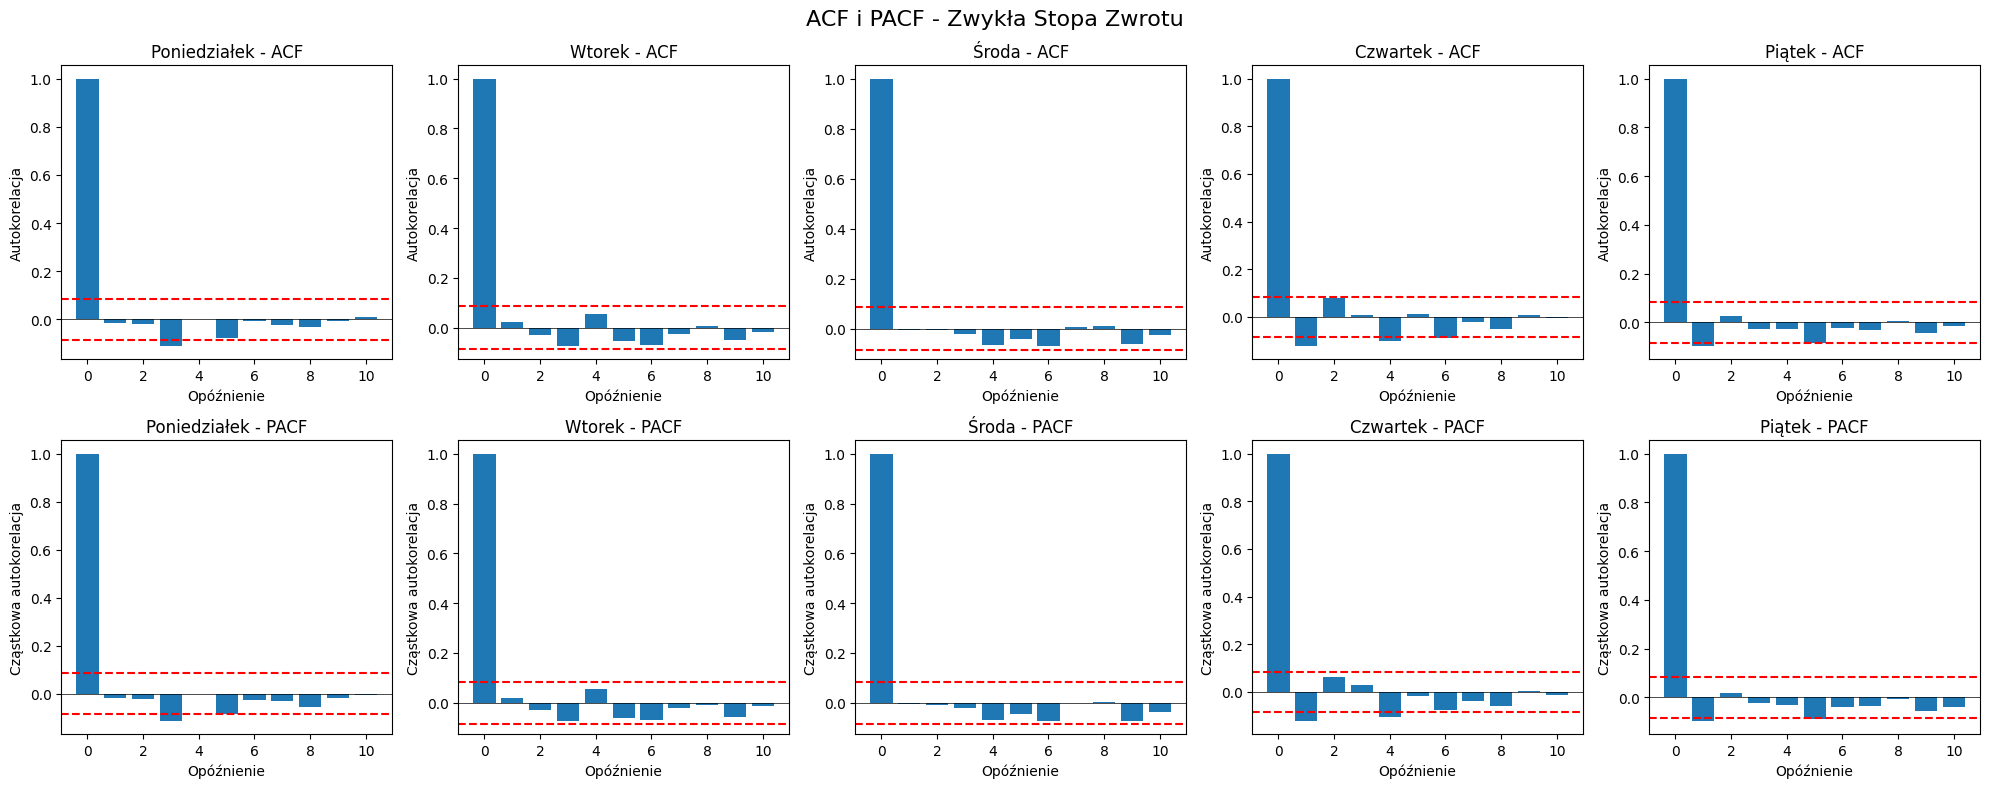

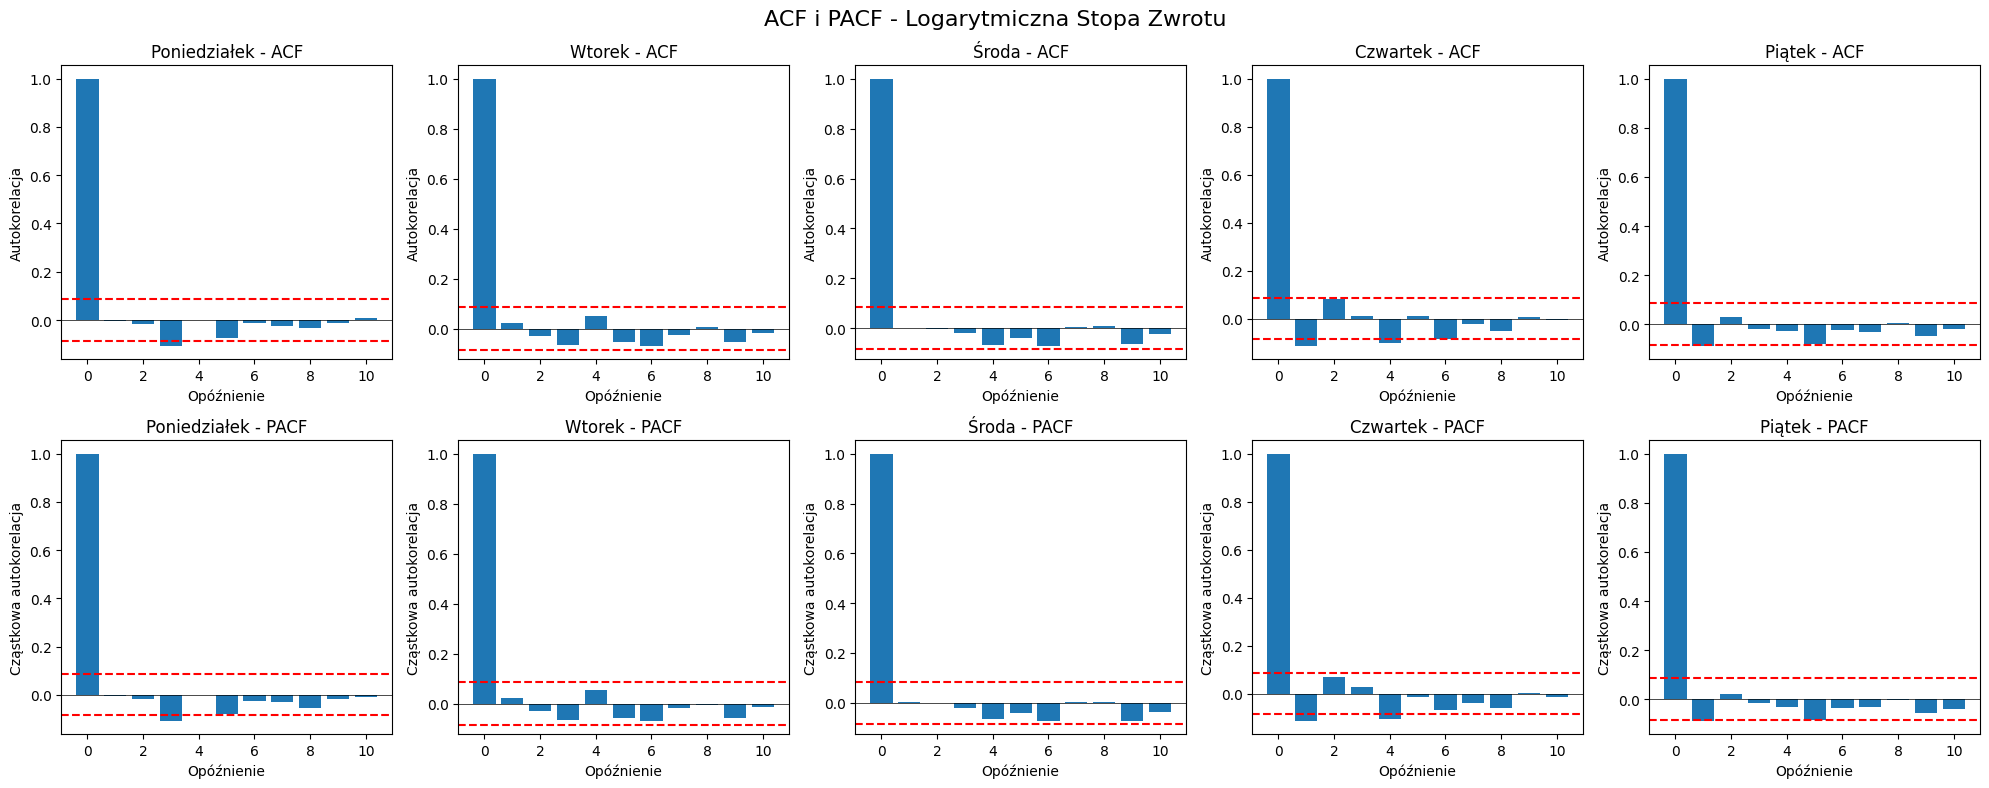

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('ACF i PACF - Zwykła Stopa Zwrotu', fontsize=16)

for idx, (dzien, df) in enumerate(wyniki.items()):
    stopy = df['Zwykla_Stopa'].dropna()
    acf_vals = acf(stopy, nlags=10)
    pacf_vals = pacf(stopy, nlags=10)

    # ACF
    axes[0, idx].bar(range(len(acf_vals)), acf_vals)
    axes[0, idx].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    axes[0, idx].axhline(y=1.96/np.sqrt(len(stopy)), color='r', linestyle='--')
    axes[0, idx].axhline(y=-1.96/np.sqrt(len(stopy)), color='r', linestyle='--')
    axes[0, idx].set_title(f"{dni_tygodnia_pl.get(dzien, dzien)} - ACF")
    axes[0, idx].set_xlabel('Opóźnienie')
    axes[0, idx].set_ylabel('Autokorelacja')

    # PACF
    axes[1, idx].bar(range(len(pacf_vals)), pacf_vals)
    axes[1, idx].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    axes[1, idx].axhline(y=1.96/np.sqrt(len(stopy)), color='r', linestyle='--')
    axes[1, idx].axhline(y=-1.96/np.sqrt(len(stopy)), color='r', linestyle='--')
    axes[1, idx].set_title(f"{dni_tygodnia_pl.get(dzien, dzien)} - PACF")
    axes[1, idx].set_xlabel('Opóźnienie')
    axes[1, idx].set_ylabel('Cząstkowa autokorelacja')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('ACF i PACF - Logarytmiczna Stopa Zwrotu', fontsize=16)

for idx, (dzien, df) in enumerate(wyniki.items()):
    stopy = df['Log_Stopa'].dropna()
    acf_vals = acf(stopy, nlags=10)
    pacf_vals = pacf(stopy, nlags=10)

    # ACF
    axes[0, idx].bar(range(len(acf_vals)), acf_vals)
    axes[0, idx].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    axes[0, idx].axhline(y=1.96/np.sqrt(len(stopy)), color='r', linestyle='--')
    axes[0, idx].axhline(y=-1.96/np.sqrt(len(stopy)), color='r', linestyle='--')
    axes[0, idx].set_title(f"{dni_tygodnia_pl.get(dzien, dzien)} - ACF")
    axes[0, idx].set_xlabel('Opóźnienie')
    axes[0, idx].set_ylabel('Autokorelacja')

    # PACF
    axes[1, idx].bar(range(len(pacf_vals)), pacf_vals)
    axes[1, idx].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    axes[1, idx].axhline(y=1.96/np.sqrt(len(stopy)), color='r', linestyle='--')
    axes[1, idx].axhline(y=-1.96/np.sqrt(len(stopy)), color='r', linestyle='--')
    axes[1, idx].set_title(f"{dni_tygodnia_pl.get(dzien, dzien)} - PACF")
    axes[1, idx].set_xlabel('Opóźnienie')
    axes[1, idx].set_ylabel('Cząstkowa autokorelacja')

plt.tight_layout()
plt.show()

Porównanie wartości oczekiwanych


In [ ]:

print("PORÓWNANIE WARTOŚCI OCZEKIWANYCH - ZWYKŁA STOPA")

stopy_lista = [df['Zwykla_Stopa'].dropna() for dzien, df in wyniki.items()]
f_stat, p_val = f_oneway(*stopy_lista)
print(f"ANOVA F-statistic: {f_stat:.4f}, p-value: {p_val:.6f}")

kruskal_stat, kruskal_p = kruskal(*stopy_lista)
print(f"Kruskal-Wallis H-statistic: {kruskal_stat:.4f}, p-value: {kruskal_p:.6f}")

print("\nPORÓWNANIE WARTOŚCI OCZEKIWANYCH - LOG STOPA")

stopy_log_lista = [df['Log_Stopa'].dropna() for dzien, df in wyniki.items()]
f_stat_log, p_val_log = f_oneway(*stopy_log_lista)
print(f"ANOVA F-statistic: {f_stat_log:.4f}, p-value: {p_val_log:.6f}")

kruskal_stat_log, kruskal_p_log = kruskal(*stopy_log_lista)
print(f"Kruskal-Wallis H-statistic: {kruskal_stat_log:.4f}, p-value: {kruskal_p_log:.6f}")


PORÓWNANIE WARTOŚCI OCZEKIWANYCH - ZWYKŁA STOPA
ANOVA F-statistic: 0.0015, p-value: 0.999995
Kruskal-Wallis H-statistic: 0.6659, p-value: 0.955465

PORÓWNANIE WARTOŚCI OCZEKIWANYCH - LOG STOPA
ANOVA F-statistic: 0.0013, p-value: 0.999997
Kruskal-Wallis H-statistic: 0.6659, p-value: 0.955465


Porównanie wariancji


In [ ]:

print("PORÓWNANIE WARIANCJI - ZWYKŁA STOPA")

levene_stat, levene_p = levene(*stopy_lista)
print(f"Levene test statistic: {levene_stat:.4f}, p-value: {levene_p:.6f}")

bartlett_stat, bartlett_p = bartlett(*stopy_lista)
print(f"Bartlett test statistic: {bartlett_stat:.4f}, p-value: {bartlett_p:.6f}")

print("\nPORÓWNANIE WARIANCJI - LOG STOPA")

levene_stat_log, levene_p_log = levene(*stopy_log_lista)
print(f"Levene test statistic: {levene_stat_log:.4f}, p-value: {levene_p_log:.6f}")

bartlett_stat_log, bartlett_p_log = bartlett(*stopy_log_lista)
print(f"Bartlett test statistic: {bartlett_stat_log:.4f}, p-value: {bartlett_p_log:.6f}")


PORÓWNANIE WARIANCJI - ZWYKŁA STOPA
Levene test statistic: 1.1392, p-value: 0.336113
Bartlett test statistic: 11.1338, p-value: 0.025101

PORÓWNANIE WARIANCJI - LOG STOPA
Levene test statistic: 1.0747, p-value: 0.367299
Bartlett test statistic: 9.8356, p-value: 0.043291
